## Group 22 Project Proposal

Jorge Martinez, Diego Islas, Jocelyn Chan, Faraaz Jan

## Introduction:

Everyone has at some point heard, either from a doctor or a person who has visited one, about the risk factors that lead to heart disease. Most professionals cite things like blood pressure, obesity, blood sugar level, diabetes, blood-cholesterol concentration and the like as factors that cause heart disease. With this in mind, we'll be working with the UC Irvine Heart Disease dataset to answer our question: **Can age, cholesterol levels and maximum heart rate be used to predict a heart disease diagnosis?**


The dataset contains fourteen variables age, sex, chest pain type, resting blood pressure in mmHg(millimeters of mercury), cholesterol levels in mg/dl(milligrams per deciliter), whether the patient's fasting blood sugar is above 120mg/dl, type of resting electrocardiographic results, patient's maximum heart rate(bpm), whether exercise induced chest pain in a patient, the ST depression induced by exercise, the slope of the ST segment at peak exercise, the amount of blood vessels analyzed for a patient, whether the patient has Thalassemia(blood disorder), and finally heart disease diagnosis.

## Preliminary exploratory data analysis:

**Library imports:**

In [2]:
#ESSENTIAL LIBRARIES AND SEED STUFF
set.seed(2000) #NEVER CHANGE
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

**Reading the dataset in from the web, tidying and selecting relevant variables**:

In [5]:
#Dataset reading
col_names <-c("age", "sex", "chest_pain_type", "resting_blood_pressure", "cholesterol_concentration", "fasting_blood_sugar_greater",
              "resting_electro", "max_bpm", "induced_pain", "ST_depression","slope_of_st_seg", "amount_of_vessels_checked", "thalassemia", "diagnosis")

# append two dataframes to make an approproately sized dataset (cleveland and hungary together)
heart_disease_data <- read_csv("https://github.com/dislasriv/DSCI-100-Group-22-Project/raw/main/dataset/heart.csv", col_names = c(col_names), skip = 1) |>                     
                        #Selection of relevant columns
                        select(age, cholesterol_concentration, max_bpm, diagnosis) |>
                        #Mutations to make data more easily readable
                       mutate(diagnosis = as_factor(diagnosis)) |>
                       mutate(diagnosis =fct_recode(diagnosis, "Yes" = "1", "No" = "0"))

#print 6 random rows to demonstrate tidyness
sample_n(heart_disease_data, 6)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, chest_pain_type, resting_blood_pressure, cholesterol_con...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,cholesterol_concentration,max_bpm,diagnosis
<dbl>,<dbl>,<dbl>,<fct>
62,164,145,No
45,234,175,Yes
58,234,156,No
58,234,156,No
63,254,147,No
66,212,132,No


**Splitting the data:**

In [6]:
data_split <- initial_split(heart_disease_data, prop = 0.75, strata = diagnosis)
training_set <- training(data_split)
testing_set <- testing(data_split)

**Summary Tables (using only training data):**

Table 1: Counts of each observation

In [7]:
num_obs <- training_set |>
            group_by(diagnosis) |>
            summarize(observation_count = n())
num_obs

diagnosis,observation_count
<fct>,<int>
No,374
Yes,394


From this table, we see that the two possible classification observations are roughly equal in proportion.

Table 2: Means, Minima and Maxima of our predictors

In [8]:

mean_min_max <- select(training_set, age, cholesterol_concentration, max_bpm) |>
                pivot_longer(age:max_bpm,
                             names_to = "predictor",
                             values_to = "value") |>
                group_by(predictor) |>
                summarize(average = mean(value,na.rm = TRUE), maximum = max(value,na.rm = TRUE), minimum = min(value,na.rm = TRUE))
             
mean_min_max

predictor,average,maximum,minimum
<chr>,<dbl>,<dbl>,<dbl>
age,54.44531,77,29
cholesterol_concentration,245.35677,564,126
max_bpm,149.63672,202,71


This table here gives us a good idea of what kinds of values are expected or extreme for each predictor, which can help us identify unexpected behaviour if extreme values don't yield expected classifications.

**Visualization of one of our relevant plots (using only training data):**

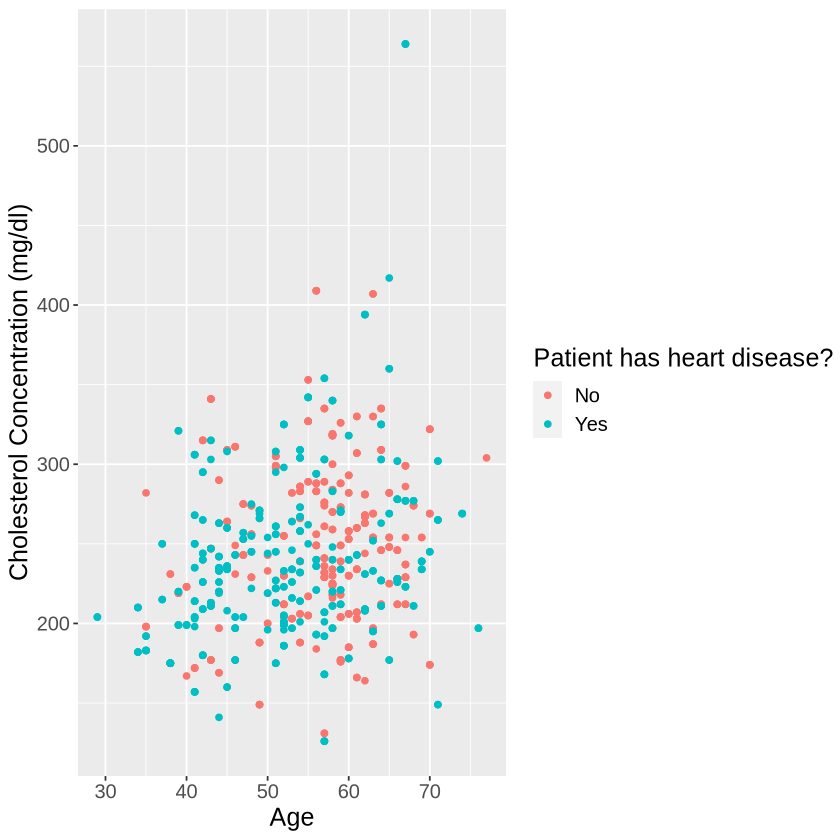

In [9]:
heart_disease_data <- heart_disease_data |>
        mutate(diagnosis = as_factor(diagnosis))

heart_disease_plot <- ggplot(data=training_set, aes(x=age, y=cholesterol_concentration))+
                     geom_point(aes(colour = diagnosis))+
                     labs(x = "Age", y = "Cholesterol Concentration (mg/dl)", colour = "Patient has heart disease?")+
                     theme(text = element_text(size = 15))
heart_disease_plot


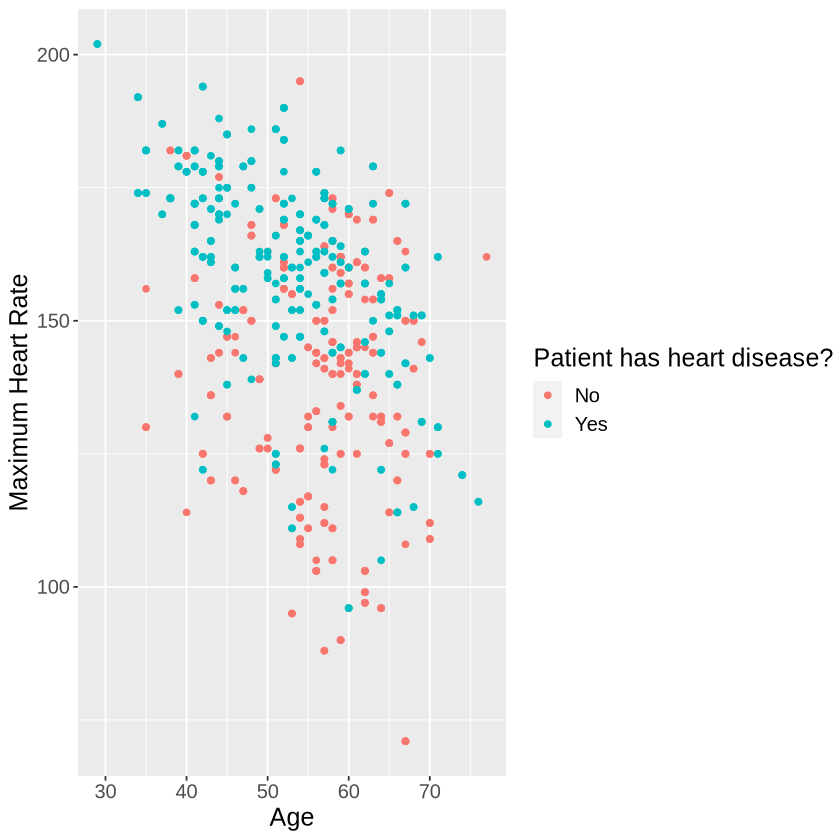

In [10]:
heart_disease_data <- heart_disease_data |>
        mutate(diagnosis = as_factor(diagnosis))

heart_disease_plot <- ggplot(data=training_set, aes(x=age, y=max_bpm))+
                     geom_point(aes(colour = diagnosis))+
                     labs(x = "Age", y = "Maximum Heart Rate", colour = "Patient has heart disease?")+
                     theme(text = element_text(size = 15))
heart_disease_plot


Given that we are using cholesterol, age, and maximum heart rate as predictors, we will most likely use these plots extensively to see how cholesterol and max heart rate differ with age and understand which variables influeces a diagnosis more heavily.

## Methods:
To conduct our analysis we're going to test a classifier on our data using the K-Nearest Neighbors algorithm. Our predictors include cholesterol levels, maximum heart rate, and age. After training and tuning the classifier, we will run it on our test set, based on the accuracy values we yield, we will conclude the answer to our question. To visualize our results we will make plots to show trends (or lack therof) between predictors and heart disease, we will also make a plot using our tuning metrics to visually show what the maximum accuracy was for our classifer as we tuned it with different neighbor counts.

## Expected outcomes and significance:

We expect that observations with higher values for our predictors are more likely to be classified as having heart disease, as is the societal notion.


The result of this data analysis could have several impacts. Say a correlation is found between our predictors and heart disease, in the real world, these results would likely not sitr up the pot too much. However, our visualizations and trends may possibly yield new data that can change how governments and society approach the fight against heart disease. If no correlation is found, this may challenge previously held societal notions of what causes heart disease. In the real world, this could revolutionize treatment and research for the disease, debunk a societal myth, and potentially cause the scientific community to come together and rediscuss heart disease as a whole.


One question that could arise from these findings is whether there are any other factors apart from our predictors that contribute to an increased risk of developing heart disease.
